# Training and Experiment Tracking with CNNs on MNIST

This notebook demonstrates how to train a Convolutional Neural Network (CNN) on the MNIST dataset and track the training process using **Comet.ml**. The goal is to experiment with different architectures and hyperparameters, log the results, and analyze the performance of the models.

## Sections:
1. **Imports**: Load the necessary libraries and set up the environment.
2. **Dataset Preparation**: Load and preprocess the MNIST dataset.
3. **Plot Random Images**: Plot 36 random images from MNIST dataset.
4. **Model Building**: Define the Fully Connected Neural Network (FCNN) and CNN architectures.
5. **Experiment Tracking**: Use Comet.ml to log hyperparameters, metrics, and results.
6. **Training and Evaluation**: Train the models and evaluate their performance on the test dataset.
7. **Results**: Visualize the results and predictions.
8. **Trying Best model**: We use the best-performing model to make predictions on new data.


## Imports

In this section, we import the required libraries for the notebook. Here's a breakdown of the key imports:

- **`dotenv`**: Used to load environment variables from a `.env` file. This is particularly useful for securely storing sensitive information like the Comet API key.
- **`comet_ml`**: Enables experiment tracking and logging to the Comet.ml platform.
- **`tensorflow`**: Provides tools for building and training neural networks.
- **`matplotlib` and `numpy`**: Used for data visualization and numerical operations.
- **`cv2`**: Used for image preprocessing when working with custom input images.

### Why Use `dotenv`?
The `dotenv` library allows us to securely load the Comet API key from a `.env` file instead of hardcoding it into the notebook. This ensures that sensitive information is not exposed in the code and can be easily managed across different environments.


In [5]:
import os

from dotenv import load_dotenv
import comet_ml

# Import Tensorflow 2.0 - 
# pip install tensorflow-macos (optimized version)
# pip install tensorflow-metal (GPU acceleration)
import tensorflow as tf

# other packages
import matplotlib.pyplot as plt
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor
import ipywidgets as widgets
from ipycanvas import Canvas
from IPython.display import display

In [6]:
# Check that we are using a GPU, if not switch runtimes
# using Runtime > Change Runtime Type > GPU
print("GPUs available:", tf.config.list_physical_devices('GPU'))
assert len(tf.config.list_physical_devices('GPU')) > 0

# load and set up comet_ml api key
load_dotenv()
COMET_API_KEY = os.getenv("COMET_API_KEY")
assert COMET_API_KEY != "", "Please insert your Comet API Key"

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset Preparation

The MNIST dataset is a collection of 70,000 grayscale images of handwritten digits (0-9), commonly used for training and testing machine learning models. Each image is 28x28 pixels in size.

### Dataset Structure:
- **Training Set**: 60,000 images and their corresponding labels.
- **Test Set**: 10,000 images and their corresponding labels.

When we load the dataset using TensorFlow's `tf.keras.datasets.mnist.load_data()` function, it returns two tuples:
1. `(train_images, train_labels)`: The training images and their labels.
2. `(test_images, test_labels)`: The test images and their labels.

### Shape of the Data:
- `train_images.shape`: `(60000, 28, 28)`  
  This means there are 60,000 training images, each of size 28x28 pixels.
- `test_images.shape`: `(10000, 28, 28)`  
  This means there are 10,000 test images, each of size 28x28 pixels.

### Preparing the Dataset:
Before feeding the data into a Convolutional Neural Network (CNN), we need to preprocess it. This involves two key steps:

1. **Normalization**:
   - The pixel values in the images range from 0 to 255. We normalize these values to the range [0, 1] by dividing each pixel value by 255.0.
   - Normalization helps the model train faster and improves numerical stability.

2. **Adding an Extra Channel Dimension**:
   - The original images are 2D arrays of shape `(28, 28)`. CNNs, however, expect input images to have an additional channel dimension, typically used for color channels (e.g., RGB).
   - Since MNIST images are grayscale, we add a single channel dimension to make the shape `(28, 28, 1)`. This is done using `np.expand_dims()`.

### Why Add the Extra Channel Dimension?
- The extra channel dimension is required because CNNs are designed to process multi-channel images (e.g., RGB images with 3 channels).
- For grayscale images like MNIST, the single channel dimension indicates that there is only one intensity value per pixel.

### Final Dataset Shapes:
- `train_images.shape`: `(60000, 28, 28, 1)`  
  60,000 training images, each of size 28x28 with 1 channel.
- `test_images.shape`: `(10000, 28, 28, 1)`  
  10,000 test images, each of size 28x28 with 1 channel.


In [7]:
# LOAD DATASET
mnist = tf.keras.datasets.mnist.load_data()

(train_images, train_labels), (test_images, test_labels) = mnist

print("Training images shape: ", train_images.shape)
print("Training labels shape: {}".format(train_labels.shape))
print("Testing images shape: {}".format(tf.shape(test_images)))
print(f"Test labels shape: {test_labels.shape} ")

Training images shape:  (60000, 28, 28)
Training labels shape: (60000,)
Testing images shape: [10000    28    28]
Test labels shape: (10000,) 


In [8]:
# PREPARE DATASET FOR CNN
# Adjust the shape of the images and normalize pixel values in the range [0,1]
print(f"{' Not normalized image values ':-^100}")
print(train_images[0])
# Mnist dataset contains images of size 28x28 and pixel values in the range [0,255]

train_images = (np.expand_dims(train_images, axis = -1)/255.0).astype(np.float32)
test_images = (np.expand_dims(test_images, axis = -1)/255.0).astype(np.float32)
train_labels = train_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)

print(f"{' Printing train_images values ':-^100}")
print(train_images[0])

----------------------------------- Not normalized image values ------------------------------------
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93 

## Plot Random Images

In this section, we visualize 36 randomly selected images from the MNIST training dataset. This helps us understand the structure of the data and verify that the images are loaded correctly.

### How It Works:
1. **Random Selection of Images**:
   - We use the `np.random.choice()` function to randomly select 36 indices from the training dataset without replacement. This ensures that the same image is not selected more than once.
   - Example:
     ```python
     random_indices = np.random.choice(train_images.shape[0], 36, replace=False)
     ```
     - `train_images.shape[0]`: The total number of training images (60,000).
     - `36`: The number of random indices to select.
     - `replace=False`: Ensures that the same index is not selected multiple times.

2. **Plotting the Images**:
   - We use `matplotlib` to create a 6x6 grid of subplots, where each subplot displays one of the randomly selected images.
   - The `cmap=plt.cm.binary` argument is used to display the images in grayscale. This ensures that the pixel intensity values (ranging from 0 to 1 after normalization) are represented as shades of black and white.

### Why Use `cmap=plt.cm.binary`?
- The MNIST dataset contains grayscale images, so using the `binary` colormap ensures that the images are displayed in their original format (black and white).
- Without specifying `cmap`, the images might be displayed using a default colormap, which could add unnecessary colors.

### Visualization:
Each subplot shows:
- The image of the handwritten digit.
- The corresponding label (actual digit) and the index of the image in the dataset.

This visualization provides a quick overview of the dataset and helps verify that the data preprocessing steps (e.g., normalization and adding the channel dimension) were applied correctly.

------------------------------------ Plotting 36 random images -------------------------------------
------------------------------------- Randomly selected images -------------------------------------
Random indices: [24135 42833 20855 35673 29365 55728 27442 38630 13273 28706  9022  4650
 36468 26990 39123 46989 41192 29716 33095 55943 39259 59103  1221 37831
    54  7657 14227 20831  2029 27048 37817 25904 12820 14473  4211 46953]
--------------------------------------- Plotting the images ----------------------------------------
----------------------------------- Logging the images to Comet ------------------------------------


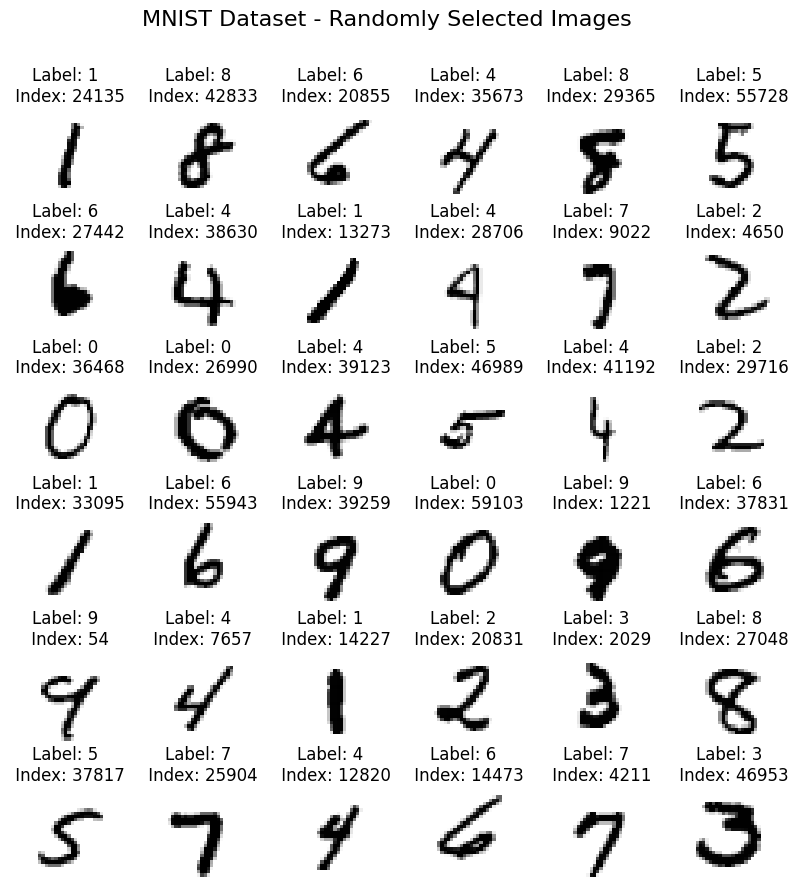

In [9]:
# Plot 36 random images from the dataset
print(f"{ ' Plotting 36 random images ':-^100}")

print(f"{' Randomly selected images ':-^100}")
random_indices = np.random.choice(train_images.shape[0],36,replace = False)
print(f"Random indices: {random_indices}")

print(f"{' Plotting the images ':-^100}")

plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_indices[i]], cmap = plt.cm.binary)
    plt.axis('off')
    title = f"Label: {train_labels[random_indices[i]]} \n Index: {random_indices[i]}"
    plt.title(title)

plt.subplots_adjust(hspace=0.5)
plt.suptitle("MNIST Dataset - Randomly Selected Images", fontsize=16)

print(f"{' Logging the images to Comet ':-^100}")


## Model Building

In this section, we define the hyperparameters and experiments for training our models. Each experiment is represented as a dictionary containing the following details:
- **Architecture**: The type of neural network to use (FCNN or CNN).
- **Optimizer**: The optimization algorithm for training (e.g., SGD or Adam).
- **Learning Rate**: The step size for updating weights during training.
- **Batch Size**: The number of samples processed before updating the model.
- **Number of Epochs**: The number of times the model will see the entire dataset during training.
- **Loss Function**: The function used to measure the error between predictions and actual labels.

### Two Main Architectures:
1. **FCNN (Fully Connected Neural Network)**:
   - This is a simple type of neural network where every neuron in one layer is connected to every neuron in the next layer.
   - It works well for structured data but may struggle with image data because it doesn't take spatial relationships (like pixel positions) into account.

2. **CNN (Convolutional Neural Network)**:
   - This is a more advanced type of neural network designed specifically for image data.
   - It uses convolutional layers to detect patterns like edges, shapes, and textures in images, making it highly effective for tasks like image classification.

### Experiment Setup:
We define multiple experiments to test different combinations of architectures, optimizers, and learning rates. This allows us to compare their performance and find the best configuration.


In [26]:
# DEFINE HYPERPARAMETERES + Experiment creation

# Define all the experiments and their hyperparameters
experiments = [
    # {"arquitecture": "FCNN", "optimizer": "SGD", "learning_rate": 0.005, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "FCNN", "optimizer": "SGD", "learning_rate": 0.001, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "FCNN", "optimizer": "SGD", "learning_rate": 0.05, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "FCNN", "optimizer": "SGD", "learning_rate": 0.01, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "CNN", "optimizer": "Adam", "learning_rate": 0.005, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "CNN", "optimizer": "Adam", "learning_rate": 0.001, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    {"arquitecture": "CNN", "optimizer": "Adam", "learning_rate": 0.0005, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "CNN", "optimizer": "Adam", "learning_rate": 0.0001, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "FCNN", "optimizer": "Adam", "learning_rate": 0.0005, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "FCNN", "optimizer": "Adam", "learning_rate": 0.0001, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "FCNN", "optimizer": "Adam", "learning_rate": 0.005, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "FCNN", "optimizer": "Adam", "learning_rate": 0.001, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "CNN", "optimizer": "SGD", "learning_rate": 0.05, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "CNN", "optimizer": "SGD", "learning_rate": 0.01, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "CNN", "optimizer": "SGD", "learning_rate": 0.005, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
    # {"arquitecture": "CNN", "optimizer": "SGD", "learning_rate": 0.001, "batch_size": 64, "num_epochs": 5, "loss_function": "sparse_categorical_crossentropy"},
]


### Understanding FCNN and CNN Networks

In this notebook, we use two types of neural networks: **Fully Connected Neural Networks (FCNN)** and **Convolutional Neural Networks (CNN)**. Here's a simple explanation of how they work and why certain design choices are made.

### Fully Connected Neural Network (FCNN)
- An FCNN is a basic type of neural network where every neuron in one layer is connected to every neuron in the next layer.
- It processes data in a flat, one-dimensional format, which means it doesn't take into account the spatial structure of images (e.g., the arrangement of pixels).
- FCNNs are simple and work well for structured data but are less effective for image data because they ignore spatial relationships.

### Convolutional Neural Network (CNN)
- A CNN is specifically designed for image data. It uses **convolutional layers** to detect patterns like edges, shapes, and textures in images.
- CNNs preserve the spatial structure of images, making them much better suited for tasks like image classification.

### Key Components of CNN:
1. **Convolutional Layers**:
   - These layers apply filters (small matrices) to the input image to detect patterns.
   - The number of filters increases from the first to the second convolutional layer because:
     - The first layer detects simple patterns like edges.
     - The second layer combines these simple patterns to detect more complex features like shapes or textures.

2. **Max Pooling Layers**:
   - These layers reduce the size of the feature maps by taking the maximum value in small regions.
   - This helps reduce the computational cost and makes the model more robust to small changes in the input.

3. **Flatten Layer**:
   - After the convolutional and pooling layers, the feature maps are still in a 2D format.
   - The **Flatten layer** converts these 2D feature maps into a 1D vector so they can be passed to the fully connected layers for classification.

4. **Fully Connected Layers**:
   - These layers take the flattened vector and learn to classify the image based on the features extracted by the convolutional layers.

5. **Softmax Activation Function**:
   - The output layer uses the **softmax activation function** because:
     - It converts the raw output values (logits) into probabilities.
     - Each probability represents the likelihood of the input belonging to a specific class (e.g., digits 0-9 in the MNIST dataset).
     - The sum of all probabilities is 1, making it easy to interpret the model's predictions.

### Why These Design Choices?
- **Increasing Filters**: By increasing the number of filters in deeper layers, the model can learn more complex and abstract features, which improves its ability to classify images accurately.
- **Flatten Layer**: This is necessary to bridge the gap between the convolutional layers (which work with 2D data) and the fully connected layers (which require 1D data).
- **Softmax Activation**: It ensures the model outputs probabilities, making it easier to interpret and evaluate the predictions.

By combining these components, CNNs are able to effectively process and classify image data, making them a powerful tool for computer vision tasks.

In [27]:
# BUILD MODELS - FCNN OR CNN

def build_model(arquitecture):
    if arquitecture == "FCNN":
        
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ])

    elif arquitecture == "CNN":
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape = (28,28,1)),
            tf.keras.layers.Conv2D(24, kernel_size=(3,3),activation = 'relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(36,kernel_size=(3,3),activation = 'relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dense(10, activation = 'softmax'),
        ])

    return model

## Experiment Tracking

The `create_experiment()` function is used to set up and manage experiments with **Comet.ml**. This function helps us log important details about each training run, such as the architecture, optimizer, and learning rate, so we can track and compare the performance of different configurations.

### How It Works:
1. **End Previous Experiments**:
   - If there is an existing experiment running, it is ended to ensure a clean start for the new experiment.

2. **Initialize a New Experiment**:
   - A new Comet experiment is created using the API key and project name. This allows us to log data to the Comet.ml platform.

3. **Log Parameters**:
   - The function logs key parameters like the architecture (e.g., FCNN or CNN)

4. **Set Experiment Name**:
   - The experiment is given a unique name based on the optimizer and learning rate, making it easier to identify in the Comet.ml dashboard.


In [22]:
# Create a Comet experiment function to track each of the training runs

comet_ml.login(
    api_key=COMET_API_KEY,
)

def create_experiment(arquitecture,optimizer, learning_rate):
  # initiate the comet experiment for tracking
  experiment_config = comet_ml.ExperimentConfig(
      name = optimizer + "_" + learning_rate,
      tags = [arquitecture],
  )

  experiment = comet_ml.start(
                  api_key=COMET_API_KEY,
                  project_name="mnist-digits",
                  mode="create",
                  experiment_config=experiment_config,
  )
  
  return experiment

COMET INFO: Valid Comet API Key saved in /Users/danism/.comet.config (set COMET_CONFIG to change where it is saved).


## Training and Evaluation

The `run_experiment()` function is responsible for running each experiment defined in the previous steps. It loops over all the experiments, builds the model, trains it, evaluates it, and logs the results using **Comet.ml**.

### How It Works:
1. **Create a Comet Experiment**:
   - For each experiment, we call the `create_experiment()` function to set up a new experiment in Comet.ml for tracking.

2. **Build the Model**:
   - The model is built based on the architecture specified in the experiment (either FCNN or CNN).

3. **Compile the Model**:
   - The `model.compile()` method is used to configure the model for training. It specifies:
     - **Loss Function**: Measures the error between the predicted and actual labels.
     - **Optimizer**: Determines how the model updates its weights during training.
     - **Metrics**: Specifies what metrics (e.g., accuracy) to track during training.

4. **Train the Model**:
   - The `model.fit()` method is used to train the model. It takes the training data and trains the model for a specified number of epochs. Key parameters include:
     - **Batch Size**: The number of samples processed before updating the model's weights.
     - **Epochs**: The number of times the model sees the entire dataset during training.

5. **Evaluate the Model**:
   - The `model.evaluate()` method is used to test the model on the test dataset. It calculates the loss and accuracy on unseen data.

6. **Log Metrics**:
   - The test loss and accuracy are logged to Comet.ml for tracking and comparison.


In [24]:
# 1 RUN EXPERIMENT


def run_experiment(exp, train_images, train_labels, test_images, test_labels):
    # CREATE COMET EXPERIMENT
    # experiment = create_experiment(exp["arquitecture"], exp["optimizer"], str(exp["learning_rate"]))

    # BUILD MODEL
    model = build_model(exp["arquitecture"])

    # COMPILE
    model.compile(
        loss = exp["loss_function"],
        optimizer = tf.keras.optimizers.get(
            {
                "class_name": exp["optimizer"],
                "config": {
                    "learning_rate": exp["learning_rate"],
                }
            }
        ),
        metrics = ['accuracy']
    )
    # TRAIN
    model.fit(train_images, train_labels,
            batch_size = exp["batch_size"],
            epochs = exp["num_epochs"],
    )

    # EVALUATE
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size = exp["batch_size"])

    # SAVE MODEL AND LOG METRICS
    model_path = "model.keras"
    model.save(model_path)

    # LOG MODEL TO COMET
    # experiment.log_model(experiment.name, model_path)

    # experiment.log_metric("test_loss", test_loss)
    # experiment.log_metric("test_accuracy", test_accuracy)
    # experiment.end()


In [25]:

for exp in experiments:
    run_experiment(exp, train_images, train_labels, test_images, test_labels)

# with ThreadPoolExecutor(max_workers=2) as executor:
#     for exp in experiments:
#         executor.submit(run_experiment, exp, train_images, train_labels, test_images, test_labels)


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8419 - loss: 0.5461
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9751 - loss: 0.0826
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9807 - loss: 0.0616
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9830 - loss: 0.0560
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9828 - loss: 0.0621
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9747 - loss: 0.1059


## Results

### 1. Overfitting
- When a machine learning model performs worse on new data (test dataset) than on the training data, it is an example of **overfitting**.
- Overfitting occurs when the model learns patterns specific to the training data but fails to generalize to unseen data.
- This is observed when the accuracy on the test dataset is lower than the accuracy on the training dataset.

### 2. Maximum Accuracy with FCNN
- The maximum accuracy achieved on the training dataset using a **Fully Connected Neural Network (FCNN)** is **0.92**.
- This result is obtained using the **Adam optimizer** with a learning rate of **0.005**.

### 3. Maximum Accuracy with CNN
- The maximum accuracy achieved on the training dataset using a **Convolutional Neural Network (CNN)** is **0.9846**.
- This result is accomplished using the **Adam optimizer** with a learning rate of **0.0005**.
- CNNs outperform FCNNs because they are better suited for image data, as they preserve spatial relationships and extract hierarchical features.

### 4. Impact of Large Learning Rates
- It is important to note that setting excessively large learning rates can cause the model to diverge and increase the loss substantially.
- For example:
  - Using **Adam** with a learning rate of **0.005** or **SGD** with a learning rate of **0.1** can lead to unstable training and poor performance.
- Proper tuning of the learning rate is crucial to ensure stable and effective training.

### Key Takeaways
- CNNs are more effective than FCNNs for image classification tasks, achieving higher accuracy.
- Careful selection of hyperparameters, such as the optimizer and learning rate, is critical for achieving optimal performance.
- Monitoring the difference between training and test accuracy helps identify overfitting and guides improvements in the model.

## Trying Best Model

After training, we use the best-performing model (CNN with **Adam optimizer** and a learning rate of **0.0005**) to make predictions on new data. This model achieved the highest accuracy during training and is well-suited for classifying handwritten digits from the MNIST dataset.

### Steps:
1. **Load the Test Image**:
   - The test image is preprocessed to match the input format expected by the model (28x28 pixels, normalized, and with a single channel).

2. **Make the Prediction**:
   - The model's `predict()` method is used to generate probabilities for each class (digits 0-9).
   - The class with the highest probability is selected as the predicted label.

3. **Visualize the Result**:
   - The test image is displayed alongside the predicted label for easy interpretation.


In [15]:
# 5 MAKE PREDICTION WITH CNN MODEL

# Download a specific model from Comet
comet_ml.login(api_key=COMET_API_KEY,)
api = comet_ml.API()
model = api.get_model(
    workspace=api.get_default_workspace(), model_name="adam_0.0005",
)
model.download("1.0.0", output_folder="./", expand=True)



COMET INFO: Valid Comet API Key saved in /Users/danism/.comet.config (set COMET_CONFIG to change where it is saved).
COMET INFO: Remote Model 'danisamper97/adam_0.0005:1.0.0' download has been started asynchronously.
COMET INFO: Still downloading 1 file(s), remaining 1.46 MB/1.46 MB
COMET WARNING: File './model.keras' has been overwritten by asset '3af9e6706fb14db880ad02ab6bf19a57' of remote model
COMET INFO: Remote Model 'danisamper97/adam_0.0005:1.0.0' has been successfully downloaded.
COMET INFO: Downloaded asset files is in './' folder.


In [16]:
# Use the downloaded model to make predictions
model = tf.keras.models.load_model("model.keras")
predictions = model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0.5, 0.98, 'MNIST Dataset - Randomly Selected Images')

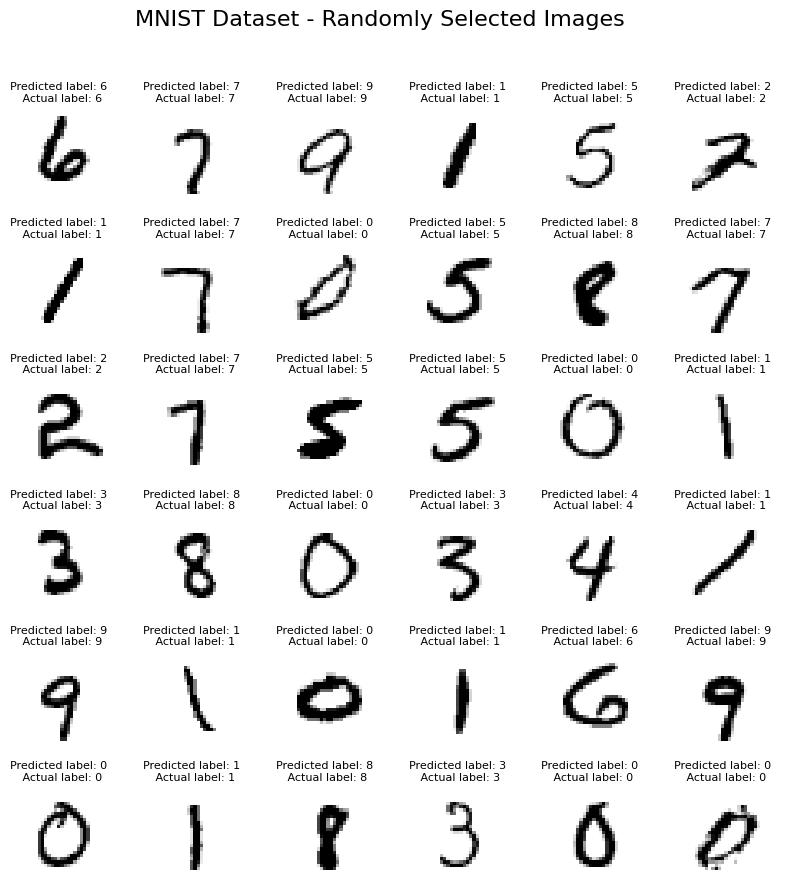

In [28]:
# Visualize the classification results
plt.figure(figsize=(10, 10))

random_indices = np.random.choice(test_images.shape[0],36,replace = False)

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random_indices[i]], cmap = plt.cm.binary)
    plt.axis('off')
    plt.title(f"Predicted label: {np.argmax(predictions[random_indices[i]])} \n Actual label: {test_labels[random_indices[i]]}", fontsize = 8)

plt.subplots_adjust(hspace=0.5)
plt.suptitle("MNIST Dataset - Randomly Selected Images", fontsize=16)

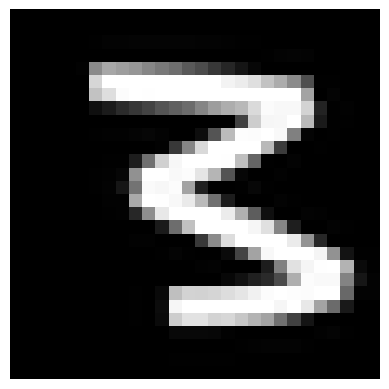

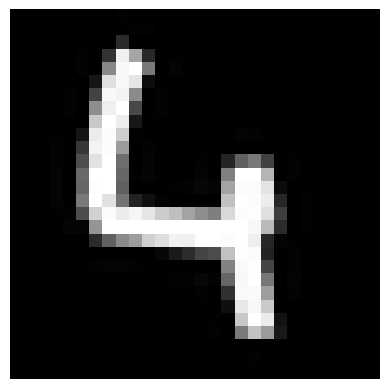

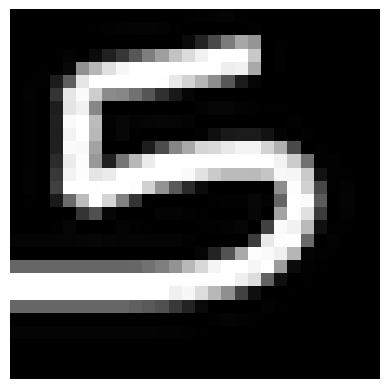

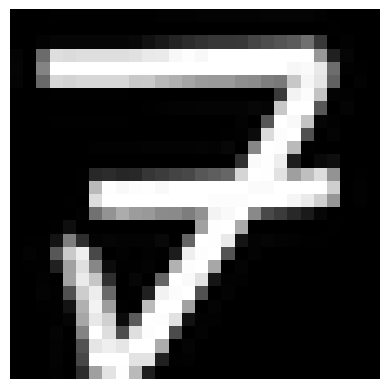

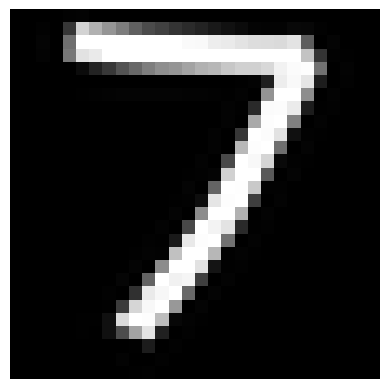

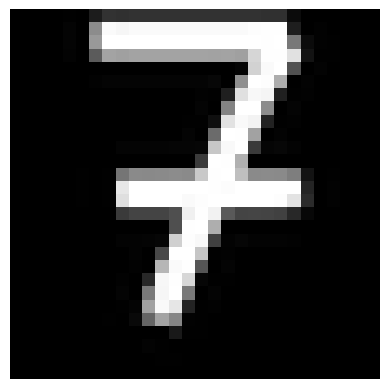

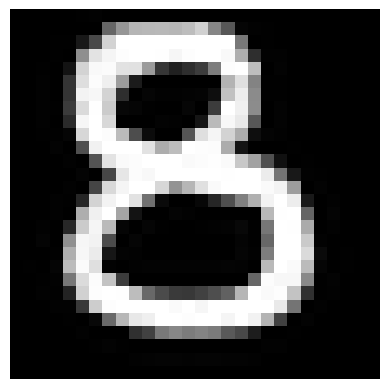

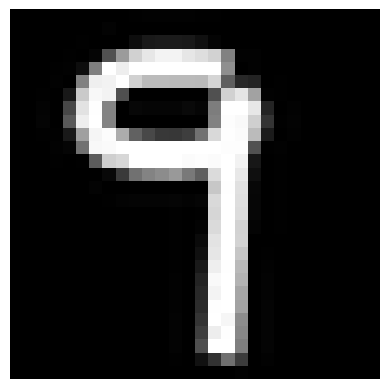

In [31]:
from ipycanvas import Canvas
from ipywidgets import Button, VBox, Label, Layout
from PIL import Image
import numpy as np
import tensorflow as tf
from IPython.display import display

# Create a smaller canvas (200x200)
canvas_size = 200
canvas = Canvas(width=canvas_size, height=canvas_size, sync_image_data=True, layout=Layout(border='3px solid black'))
canvas.layout.width = '200px'  # Resize display width
canvas.line_width = 20
canvas.stroke_style = 'black'

# Internal state to control drawing only when mouse is pressed
is_drawing = {'active': False}

# Label for prediction output
prediction_label = Label(value="Draw a digit and click 'Predict'")

# Buttons
predict_button = Button(description="Predict")
clear_button = Button(description="Clear")

# --- Drawing Control ---
def on_mouse_down(x, y):
    is_drawing['active'] = True
    canvas.begin_path()
    canvas.move_to(x, y)

def on_mouse_up(x, y):
    is_drawing['active'] = False

def on_mouse_move(x, y):
    if is_drawing['active']:
        canvas.line_to(x, y)
        canvas.stroke()
        canvas.begin_path()
        canvas.move_to(x, y)

canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_up(on_mouse_up)
canvas.on_mouse_move(on_mouse_move)

# --- Clear Function ---
def clear_canvas(b):
    canvas.clear()
    # Force redraw to prevent ghost image
    canvas.put_image_data(np.ones((canvas_size, canvas_size, 4), dtype=np.uint8) * 255, 0, 0)
    canvas.clear()
    prediction_label.value = "Canvas cleared. Draw again."

clear_button.on_click(clear_canvas)

# --- Prediction Function ---
def predict_digit(b):
    # Ensure sync_image_data=True when creating the canvas
    data = np.array(canvas.get_image_data())  # shape: (height, width, 4)

    # Convert RGBA to grayscale using the alpha channel
    grayscale = data[:, :, 3]  # Invert alpha channel to get black-on-white

    # Convert to PIL image
    img = Image.fromarray(grayscale.astype('uint8'), mode='L')
    img = img.resize((28, 28), Image.Resampling.LANCZOS)

    # Normalize and reshape for model input
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 28, 28, 1)

    plt.imshow(img_array[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()

    # Predict
    prediction = model.predict(img_array)
    predicted_digit = np.argmax(prediction)

    # Show prediction and the resized image
    prediction_label.value = f"Predicted digit: {predicted_digit}"

predict_button.on_click(predict_digit)

# --- Display Everything ---
display(VBox([canvas, predict_button, clear_button, prediction_label]))





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Layer 0 output shape: (1, 26, 26, 24)
Layer 1 output shape: (1, 11, 11, 36)


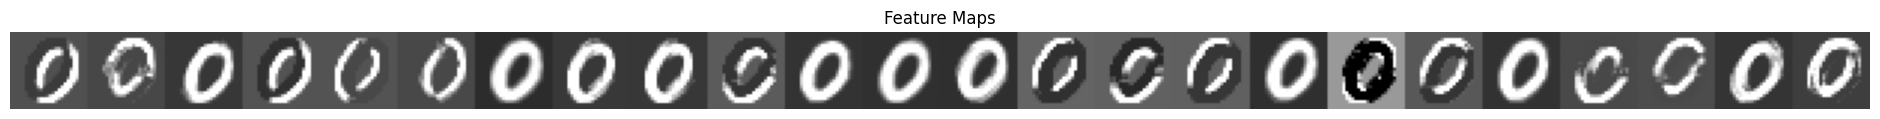

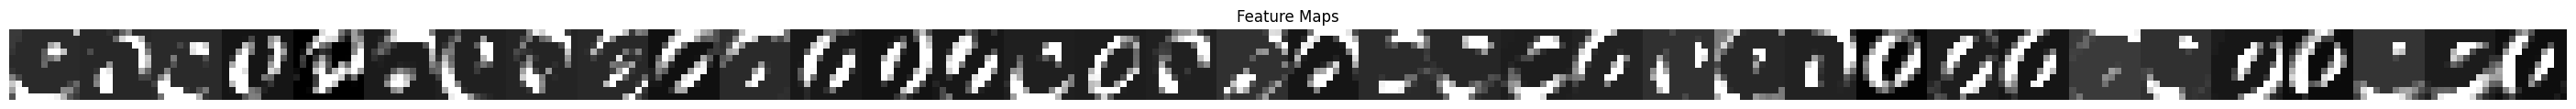

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt

# Now build the activation model
conv_layers_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
activation_model = Model(inputs=model.layers[0].input, outputs=conv_layers_outputs)

# Use a sample test image
img = test_images[np.random.choice(test_images.shape[0], 1, replace=False)]

# Ensure image has the right shape
if img.ndim == 3:
    img = img.reshape(1, 28, 28, 1)

# Run prediction and get activations
prediction = model.predict(img)
activations = activation_model.predict(img)

for idx, layer_activation in enumerate(activations):
    print(f"Layer {idx} output shape: {layer_activation.shape}")

# Plot feature maps
for layer_activation in activations:
    num_filters = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    display_grid = np.zeros((size, size * num_filters))
    for i in range(num_filters):
        x = layer_activation[0, :, :, i]
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x = np.clip(x*100+128, 0, 255).astype('uint8')
        display_grid[:, i * size:(i + 1) * size] = x

    scale = 1.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title("Feature Maps")
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='gray')
    plt.show()
